# Forecasting inflation rate of Peru

**Author**: Valerie Dube

**Date**  : May, 2024

In [2]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statsmodels
import statsmodels.api as sm
from scipy.stats import pearsonr

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from MacroRandomForest import *

### 1. Importing the database

In [3]:
df = pd.read_excel(r"./data/database_noindex.xlsx", sheet_name=0)

# Convert index to datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.set_index('fecha')

Splitting the data

In [4]:
# Delimitator
split_point = math.floor(len(df) * 0.85)

# Train data
X_train = df.iloc[:split_point, 1:].copy()
y_train = df.iloc[:split_point, 0].copy()

# Test data
X_test = df.iloc[split_point:, 1:].copy()
y_test = df.iloc[split_point:, 0].copy()

In [5]:
# Standardize the values of X
scale = StandardScaler()

X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), index=X_train.index)
X_test_scaled = pd.DataFrame(data=scale.transform(X_test), index=X_test.index)

In [6]:
df

,inflacion,inflacion_lag,rem_min_lag,pm_lag,pm_np_lag,p_minera_lag,brecha_pbi_lag,pea_ocu_lag,pea_ocu_pe_lag,pea_ocu_me_lag,...,tc_yen_lag,IPC_sin_alim_lag,IPC_sin_alim_ener_lag,IPC_alim_ener_lag,IPC_imp_lag,IPC_subyacente_lag,IPC_transables_lag,inflacion_exp_lag,economia_exp_lag,VIX_lag
fecha,,,,,,,,,,,,,,,,,,,,,
2002-07-01,-0.140234,-0.002035,1.136010,-5.662007,-2.773250,22.114517,-0.032997,11.040000,15.138000,-9.062692,...,-2.887000,-0.054630,0.044393,-0.221909,0.127722,0.085338,-0.004641,2.250000,49.393939,25.400000
2002-08-01,0.264299,-0.140234,-0.171427,2.286000,2.589879,-0.949407,-0.778864,48.813000,8.333000,-0.321548,...,-5.531000,0.073665,0.163111,-0.067423,0.165653,0.102363,0.009591,2.291667,56.231454,32.029999
2002-09-01,0.675922,0.264299,-0.503611,-7.467709,1.947175,6.232502,-0.482150,27.738000,28.477000,-4.776760,...,0.940000,-0.009628,0.081986,0.022230,0.305059,0.066439,0.030456,2.333333,57.164634,32.639999
2002-10-01,1.360751,0.675922,-2.352623,-1.330960,-1.641594,1.439875,-0.185435,10.248000,1.672000,22.472175,...,1.361000,0.199024,-0.001084,0.451931,2.573193,0.129688,0.315431,2.375000,57.624633,39.689999
2002-11-01,1.455986,1.360751,-3.541418,4.902795,-0.268489,1.770340,0.111279,-6.855000,-28.269000,19.631753,...,3.496000,-0.224354,0.036013,0.644831,1.834841,0.059873,-0.180510,2.416667,60.267857,31.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,5.044546,5.576147,-2.389237,10.132818,9.992484,6.655514,-2.886048,2.219766,11.645044,14.616994,...,3.864182,-0.040154,0.261849,0.615361,1.156728,0.341446,0.415742,4.333333,44.064748,13.570000
2023-10-01,4.343081,5.044546,-0.104174,-3.271024,-1.103879,8.722530,-2.802985,-17.287497,1.436851,-13.435883,...,3.000104,0.050204,0.144092,-0.136751,0.542867,0.262828,-0.141626,4.250000,40.405904,17.520000
2023-11-01,3.636475,4.343081,2.054512,6.223207,3.307040,3.294588,-2.719922,19.314485,47.439203,-35.773130,...,1.708128,0.001269,0.237237,-1.100675,0.314629,0.262476,-0.267952,4.166667,38.697318,18.140000


### 2. Feature selection

In this section, we will see with which set of features the linear regression has better prediction (lower MAE). We will compare the model with 1) all variables, 2) manual selection (economics theory), 4) P-value, and 3) Lasso CV

Reference: Rezazadeh Kalehbasti, P., Nikolenko, L., & Rezaei, H. (2021, August)

#### 2.1. All features

In [7]:
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_pred_var = lm.predict(X_test_scaled)

In [8]:
# Metricas de desempeño del modelo
all_features_corr = pearsonr(y_test, y_pred_var)[0]
all_feature_mae = mean_absolute_error(y_test, y_pred_var)
all_features_mse = mean_squared_error(y_test, y_pred_var)
all_features_r2 = r2_score(y_test, y_pred_var)

print(f"Correlación: {all_features_corr:.4f}")
print(f"MAE en validation: {all_feature_mae:.4f}")
print(f"MSE en validation: {all_features_mse:.4f}")
print(f"R^2 on validation: {all_features_r2:.4f}")

Correlación: 0.9739
MAE en validation: 0.4240
MSE en validation: 0.2795
R^2 on validation: 0.9486


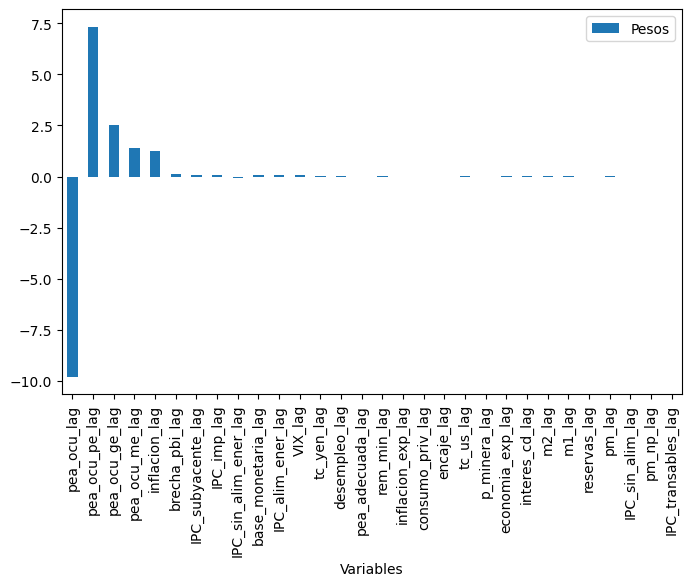

In [9]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lm.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

#### 2.2. Manual selection

In [10]:
# List of features according to economic literature
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled.iloc[:, [0, 5, 11]], y_train) # inflation lag, GDP gap lag and unemployment gap
y_pred = lm.predict(X_test_scaled.iloc[:, [0, 5, 11]])

In [11]:
# Metricas de desempeño del modelo
by_hand_corr = pearsonr(y_test, y_pred)[0]
by_hand_r2 = r2_score(y_test, y_pred)

print(f"Correlación: {by_hand_corr:.4f}")
print(f"R^2 on validation: {by_hand_r2:.4f}")

Correlación: 0.9744
R^2 on validation: 0.9427


#### 2.3. P-value selection

In [12]:
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train_scaled)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:              inflacion   R-squared (uncentered):                   0.184
Model:                            OLS   Adj. R-squared (uncentered):              0.055
Method:                 Least Squares   F-statistic:                              1.425
Date:                Sun, 02 Jun 2024   Prob (F-statistic):                      0.0816
Time:                        16:23:24   Log-Likelihood:                         -534.70
No. Observations:                 220   AIC:                                      1129.
Df Residuals:                     190   BIC:                                      1231.
Df Model:                          30                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
p_values = res.pvalues
alpha = 0.05

significant_features = []
for i, p_value in enumerate(p_values):
    if p_value < alpha:
        significant_features.append(i)

In [14]:
lm = LinearRegression()
lm.fit(X_train_scaled.loc[:, significant_features], y_train)
y_pred = lm.predict(X_test_scaled.loc[:, significant_features])

In [15]:
# Metricas de desempeño del modelo
pvalue_corr = pearsonr(y_test, y_pred)[0]
pvalue_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {pvalue_corr:.4f}")
print(f"R^2 on validation: {pvalue_r2:.4f}")

Correlación: 0.9732
R^2 on validation: 0.9413


#### 2.4. Lasso selection

In [16]:
# Se evalúan varias valores de lambda
lasso = Lasso(alpha=0.02, max_iter = 5000)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

In [17]:
# Metricas de desempenho del modelo
lasso_r2 = r2_score(y_test, y_pred)
print(f"R^2 on validation: {lasso_r2:.5f}")

R^2 on validation: 0.95354


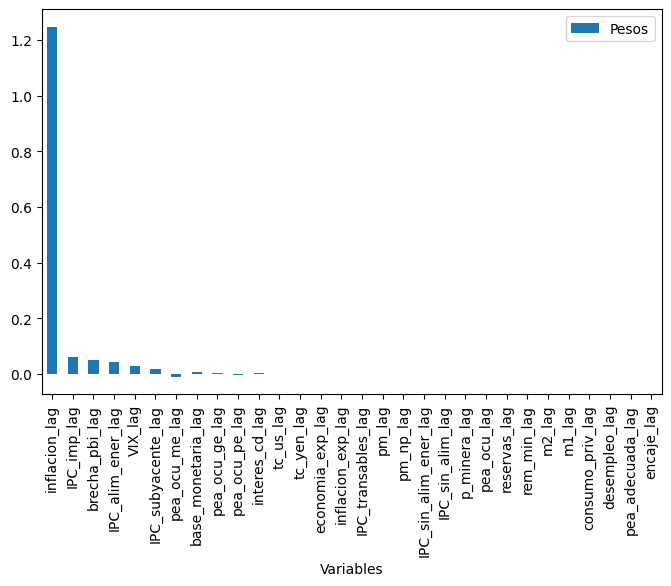

In [18]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lasso.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

In [19]:
lm = LinearRegression()
lm.fit(X_train_scaled.iloc[:, lasso.coef_!=0], y_train)
y_pred = lm.predict(X_test_scaled.loc[:, lasso.coef_!=0])

In [20]:
X_train.iloc[:, lasso.coef_!=0]

,inflacion_lag,brecha_pbi_lag,pea_ocu_pe_lag,pea_ocu_me_lag,pea_ocu_ge_lag,base_monetaria_lag,interes_cd_lag,tc_us_lag,tc_yen_lag,IPC_alim_ener_lag,IPC_imp_lag,IPC_subyacente_lag,VIX_lag
fecha,,,,,,,,,,,,,
2002-07-01,-0.002035,-0.032997,15.138,-9.062692,4.4718,203.005600,4.678474,0.04910,-2.887000,-0.221909,0.127722,0.085338,25.400000
2002-08-01,-0.140234,-0.778864,8.333,-0.321548,41.4391,521.350000,4.484431,0.04320,-5.531000,-0.067423,0.165653,0.102363,32.029999
2002-09-01,0.264299,-0.482150,28.477,-4.776760,1.9392,-1022.236400,4.131558,0.06080,0.940000,0.022230,0.305059,0.066439,32.639999
2002-10-01,0.675922,-0.185435,1.672,22.472175,-13.7106,45.071600,4.114172,0.03055,1.361000,0.451931,2.573193,0.129688,39.689999
2002-11-01,1.360751,0.111279,-28.269,19.631753,1.8996,318.545500,4.350441,-0.04320,3.496000,0.644831,1.834841,0.059873,31.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,1.781920,-19.973868,-764.900,-116.600000,-224.2000,-6075.290252,1.218175,0.04910,-0.638235,0.264964,-0.452809,0.129402,27.510000
2020-07-01,1.598732,-14.869683,-250.100,-28.100000,-73.1000,5997.417658,1.210759,0.11350,0.263235,-0.594567,0.111877,0.088284,30.430000
2020-08-01,1.861696,-9.765498,588.600,60.600000,88.2000,-5221.682324,1.079911,-0.01310,-0.857632,0.873158,0.027266,0.060051,24.459999


In [21]:
lasso_corr = pearsonr(y_test, y_pred)[0]
lasso_r2 = r2_score(y_test, y_pred)

print(f"Correlation: {lasso_corr:.4f}")
print(f"R^2 on validation: {lasso_r2:.4f}")

Correlation: 0.9731
R^2 on validation: 0.9468


#### 2.5. Comparación de resultados

In [22]:
# Comparamos los 3 modelos
df_ans = pd.DataFrame({"All features": [all_features_corr, all_features_r2], \
                       "By hand": [by_hand_corr, by_hand_r2], \
                       "P-value": [pvalue_corr, pvalue_r2], \
                       "Lasso": [lasso_corr, lasso_r2]})
df_ans.index = ["Correlacion", "R2"]
df_ans

,All features,By hand,P-value,Lasso
Correlacion,0.973949,0.974353,0.973155,0.973146
R2,0.948555,0.942748,0.941341,0.946802


### 3. Models

#### 3.1. Ridge regression

In [23]:
# Define rolling window parameters
window_size = 30  # Adjust as needed
step_size = 10

# Initialize lists to store MSE and alpha values
mse_values = []
alpha_values = []

# Iterate over rolling windows
for i in range(0, len(X_train_scaled) - window_size + 1, step_size):
    X_window = X_train_scaled.iloc[i : i + window_size]
    y_window = y_train[i : i + window_size]

    # Fit Ridge regression model
    ridge_model = RidgeCV(alphas=np.arange(1, 10, 0.5), cv=5)
    ridge_model.fit(X_window, y_window)

    # Calculate MSE on test data
    y_pred = ridge_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    mse_values.append(mse)
    alpha_values.append(ridge_model.alpha_)

# Choose the optimal alpha
optimal_alpha = alpha_values[np.argmin(mse_values)]
print(f"Optimal alpha: {optimal_alpha:.4f}")


Optimal alpha: 2.5000


In [24]:
# Fit Ridge regression model
ridge = Ridge(alpha=2.5000)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

In [25]:
# Metricas de desempenho del modelo
ridge_mae_test = mean_absolute_error(y_test, y_pred_ridge)
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge)
ridge_r2_test = r2_score(y_test, y_pred_ridge)

print(f"MAE en validation: {ridge_mae_test:.4f}")
print(f"MSE en validation: {ridge_mse_test:.4f}")
print(f"R^2 on validation: {ridge_r2_test:.4f}")

MAE en validation: 0.4356
MSE en validation: 0.2975
R^2 on validation: 0.9452


In [26]:
X_test_scaled.index

DatetimeIndex(['2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', name='fecha', freq=None)

#### 3.2 Lasso

In [27]:
# Define rolling window parameters
window_size = 30  # Adjust as needed
step_size = 10

# Initialize lists to store MSE and alpha values
mse_values = []
alpha_values = []

# Iterate over rolling windows
for i in range(0, len(X_train_scaled) - window_size + 1, step_size):
    X_window = X_train_scaled.iloc[i : i + window_size]
    y_window = y_train[i : i + window_size]

    # Fit Ridge regression model
    lasso_model = LassoCV(alphas=np.arange(0.01, 0.2, 0.0001), cv=5)
    lasso_model.fit(X_window, y_window)

    # Calculate MSE on test data
    y_pred = lasso_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    mse_values.append(mse)
    alpha_values.append(lasso_model.alpha_)

# Choose the optimal alpha
optimal_alpha = alpha_values[np.argmin(mse_values)]
print(f"Optimal alpha: {optimal_alpha:.4f}")

Optimal alpha: 0.0947


In [28]:
# Fit Ridge regression model
lasso = Lasso(alpha=0.0947)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

In [29]:
lasso_mae_test = mean_absolute_error(y_test, y_pred_lasso)
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso)
lasso_r2_test = r2_score(y_test, y_pred_lasso)

print(f"MAE en validation: {lasso_mae_test:.4f}")
print(f"MSE en validation: {lasso_mse_test:.4f}")
print(f"R^2 on validation: {lasso_r2_test:.4f}")

MAE en validation: 0.5667
MSE en validation: 0.4559
R^2 on validation: 0.9161


#### 3.3 Macroeconomic Random Forest

In [30]:
df_scaled = pd.DataFrame(scale.fit_transform(df))
df_scaled = df_scaled.set_index(df.index)

In [31]:
data = pd.concat([df.iloc[:, [0]], df_scaled.iloc[:, 1:]], axis=1)

In [32]:
# var dependiente
y_pos = data.columns.get_loc('inflacion')

### Exogenous Variables
S_vars = data.columns[1:].to_numpy()
S_pos = [data.columns.get_loc(s) for s in S_vars]

### Variables Included in Linear Equation
x_vars = data.columns[1:][lasso.coef_!=0].to_numpy()
x_pos = [data.columns.get_loc(x) for x in x_vars]

In [33]:
oos_pos = np.arange(split_point, len(data)) # Row positions of test set/out-of-sample observations

In [34]:
MRF = MacroRandomForest(data = data,
                        y_pos = y_pos,
                        x_pos = x_pos,
                        S_pos = S_pos,
                        B = 100,
                        parallelise = True,
                        n_cores = 3,
                        resampling_opt = 2,
                        oos_pos = oos_pos,
                        trend_push = 4,
                        quantile_rate = 0.3,
                        print_b = True,
                        ridge_lambda = 0.3,
                        fast_rw = True)

In [35]:
MRF_output = MRF._ensemble_loop()

Tree 3 out of 100
Tree 1 out of 100
Tree 2 out of 100
Tree 4 out of 100
Tree 5 out of 100
Tree 6 out of 100
Tree 7 out of 100
Tree 8 out of 100
Tree 9 out of 100
Tree 10 out of 100
Tree 11 out of 100
Tree 12 out of 100
Tree 13 out of 100
Tree 14 out of 100
Tree 15 out of 100
Tree 16 out of 100
Tree 17 out of 100
Tree 18 out of 100
Tree 19 out of 100
Tree 20 out of 100
Tree 21 out of 100
Tree 22 out of 100
Tree 23 out of 100
Tree 24 out of 100
Tree 25 out of 100
Tree 26 out of 100
Tree 27 out of 100
Tree 28 out of 100
Tree 29 out of 100
Tree 30 out of 100
Tree 31 out of 100
Tree 32 out of 100
Tree 33 out of 100
Tree 34 out of 100
Tree 35 out of 100
Tree 36 out of 100
Tree 37 out of 100
Tree 38 out of 100
Tree 39 out of 100
Tree 40 out of 100
Tree 41 out of 100
Tree 42 out of 100
Tree 43 out of 100
Tree 44 out of 100
Tree 45 out of 100
Tree 46 out of 100
Tree 47 out of 100
Tree 48 out of 100
Tree 49 out of 100
Tree 50 out of 100
Tree 51 out of 100
Tree 52 out of 100
Tree 53 out of 100
Tr

In [36]:
forecasts = MRF_output['pred']
betas = MRF_output['betas']

Text(0.5, 1.0, 'OOS predictions of MRF')

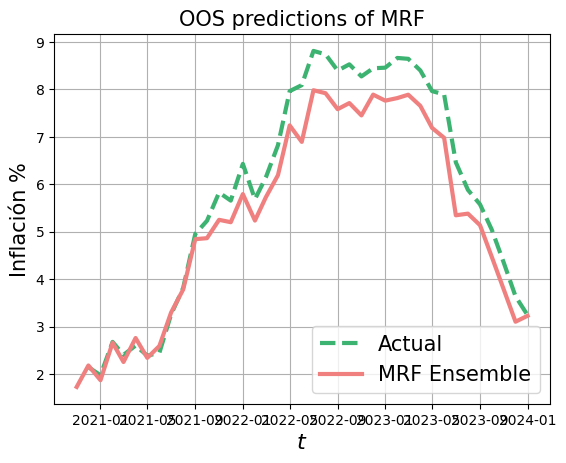

In [37]:
fig, ax = plt.subplots()
# plt.rcParams['figure.figsize'] = (10, 5)

# Plotting actual versus original
ax.plot(data.iloc[split_point:, 0].shift(1), label = 'Actual', linewidth = 3, color ='mediumseagreen', linestyle = '--')
ax.plot(data.iloc[split_point:, 0].index, forecasts, color = 'lightcoral', linewidth = 3, label = "MRF Ensemble")

ax.legend(fontsize = 15)
ax.set_ylabel("Inflación %", fontsize = 15)
ax.grid()
ax.set_xlabel(r"$t$", fontsize = 16)
ax.set_title("OOS predictions of MRF", fontsize = 15)

In [38]:
mrf_mae_test = mean_absolute_error(data.iloc[split_point:, 0], forecasts)
mrf_mse_test = mean_squared_error(data.iloc[split_point:, 0], forecasts)
mrf_r2_test = r2_score(data.iloc[split_point:, 0], forecasts)

print(f"MAE en validation: {mrf_mae_test:.4f}")
print(f"MSE en validation: {mrf_mse_test:.4f}")
print(f"R^2 on validation: {mrf_r2_test:.4f}")

MAE en validation: 0.6161
MSE en validation: 0.5644
R^2 on validation: 0.8961


#### 3.4. Neural Transformer Encoders

In [39]:
# # Divide into training and test/validation sets.
# df_train = df.iloc[:split_point, :].copy()
# df_test = df.iloc[split_point:, :].copy()

# inflation_train = df_train['inflacion'].tolist()
# inflation_test = df_test['inflacion'].tolist()

# print("Training set has {} observations.".format(len(inflation_train)))
# print("Test set has {} observations.".format(len(inflation_test)))

The to_sequences function takes linear time series data into an x and y where x is all possible sequences of seq_size. After each x sequence, this function places the next value into the y variable. These x and y data can train a time-series neural network.

In [40]:
# def to_sequences(seq_size, obs):
#     x = []
#     y = []

#     for i in range(len(obs) - SEQUENCE_SIZE):
#         #print(i)
#         window = obs[i:(i+SEQUENCE_SIZE)]
#         after_window = obs[i+SEQUENCE_SIZE]
#         window = [[x] for x in window]
#         #print("{} - {}".format(window,after_window))
#         x.append(window)
#         y.append(after_window)
        
#     return np.array(x),np.array(y)
    
    
# SEQUENCE_SIZE = 10
# x_train, y_train = to_sequences(SEQUENCE_SIZE, inflation_train)
# x_test, y_test = to_sequences(SEQUENCE_SIZE, inflation_test)

# print("Shape of training set: {}".format(x_train.shape))
# print("Shape of test set: {}".format(x_test.shape))

Next, we create the transformer_encoder. This layer includes residual connections, layer normalization, and dropout. This resulting layer can be stacked multiple times. We implement the projection layers with the Keras Conv1D.

In [41]:
# import tensorflow as tf

In [42]:
# from tensorflow import keras
# from tensorflow.keras import layers

In [43]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

The following function is provided to build the model, including the attention layer.

In [44]:
# def build_model(
#     input_shape,
#     head_size,
#     num_heads,
#     ff_dim,
#     num_transformer_blocks,
#     mlp_units,
#     dropout=0,
#     mlp_dropout=0,
# ):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1)(x)
#     return keras.Model(inputs, outputs)

We are now ready to build and train the model.

In [45]:
# input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )

# model.compile(
#     loss="mean_squared_error",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4)
# )
# #model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, \
#     restore_best_weights=True)]

# model.fit(
#     x_train,
#     y_train,
#     validation_split=0.2,
#     epochs=200,
#     batch_size=64,
#     callbacks=callbacks,
# )

# model.evaluate(x_test, y_test, verbose=1)

Finally, we evaluate the model with RMSE.

In [46]:
# pred = model.predict(x_test)
# score = np.sqrt(mean_squared_error(pred,y_test))
# print("Score (RMSE): {}".format(score))

### 4. Final graphs

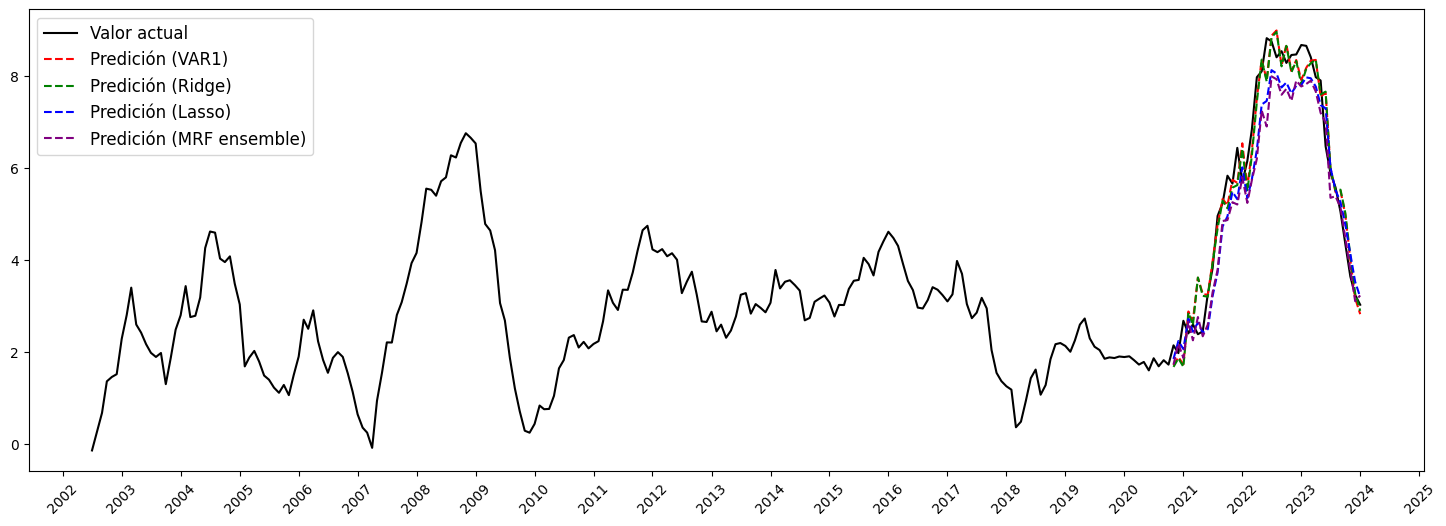

In [48]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df.index, df['inflacion'], label='Valor actual', color='black')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_var, label='Predición (VAR1)', linestyle='--', color='red')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_ridge, label='Predición (Ridge)', linestyle='--', color='green')
ax.plot(df.loc[X_test_scaled.index, :].index, y_pred_lasso, label='Predición (Lasso)', linestyle='--', color='blue')
ax.plot(df.loc[X_test_scaled.index, :].index, forecasts, label='Predición (MRF ensemble)', linestyle='--', color='purple')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
ax.legend(fontsize=12)
plt.show()

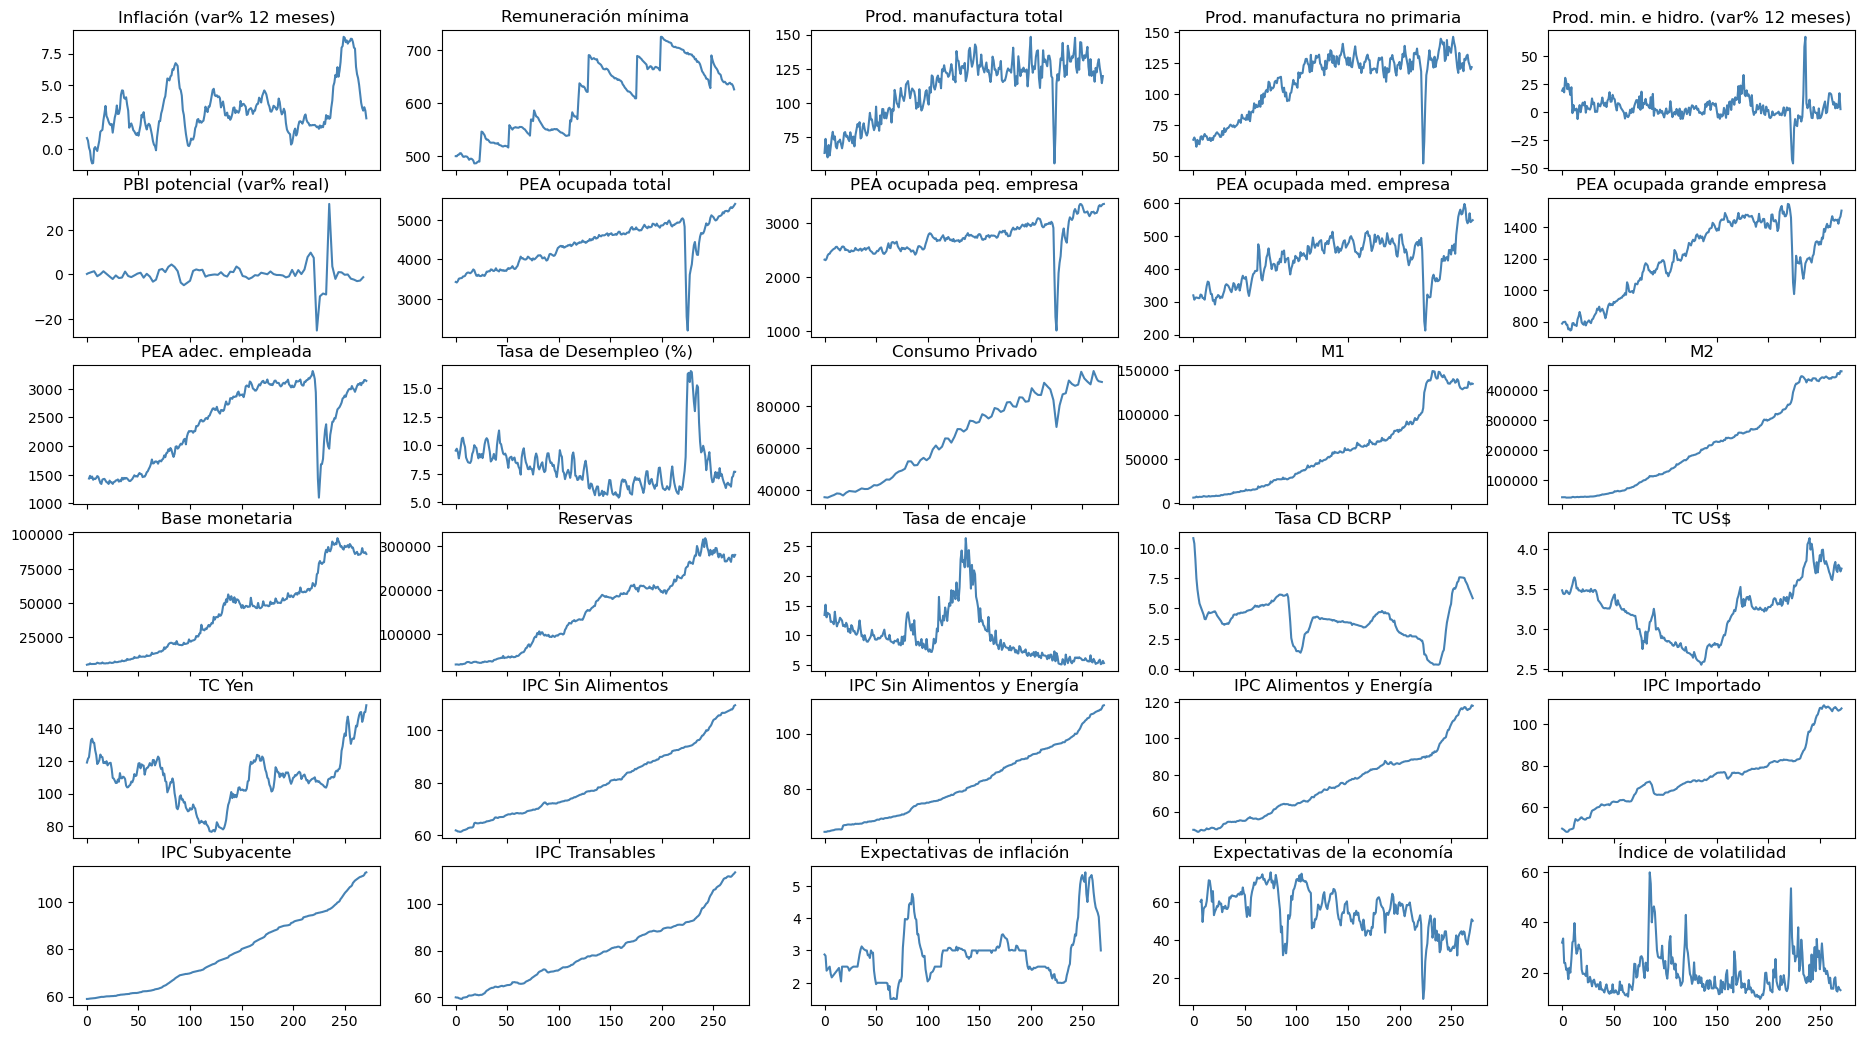

In [222]:
# Read Excel file
before_df = pd.read_excel(r"./data/raw_database.xlsx", sheet_name=0)
before_df = before_df.drop('indice_sent', axis=1)

# Graph of parameters
before_df.iloc[:, 1:].plot(kind ='line',
            subplots = True,
            figsize = (23,17),
            title = ['Inflación (var% 12 meses)', 'Remuneración mínima', 'Prod. manufactura total', 'Prod. manufactura no primaria', 'Prod. min. e hidro. (var% 12 meses)',
                     'PBI potencial (var% real)', 'PEA ocupada total', 'PEA ocupada peq. empresa', 'PEA ocupada med. empresa', 'PEA ocupada grande empresa', 
                     'PEA adec. empleada', 'Tasa de Desempleo (%)', 'Consumo Privado', 'M1', 'M2', 
                     'Base monetaria', 'Reservas', 'Tasa de encaje', 'Tasa CD BCRP', 'TC US$', 
                     'TC Yen', 'IPC Sin Alimentos', 'IPC Sin Alimentos y Energía', 'IPC Alimentos y Energía', 'IPC Importado', 
                     'IPC Subyacente', 'IPC Transables', 'Expectativas de inflación', 'Expectativas de la economía', 'Índice de volatilidad'],
            legend = False,
            layout = (8,5),
            sharex = True,
            color = 'steelblue')
plt.show()

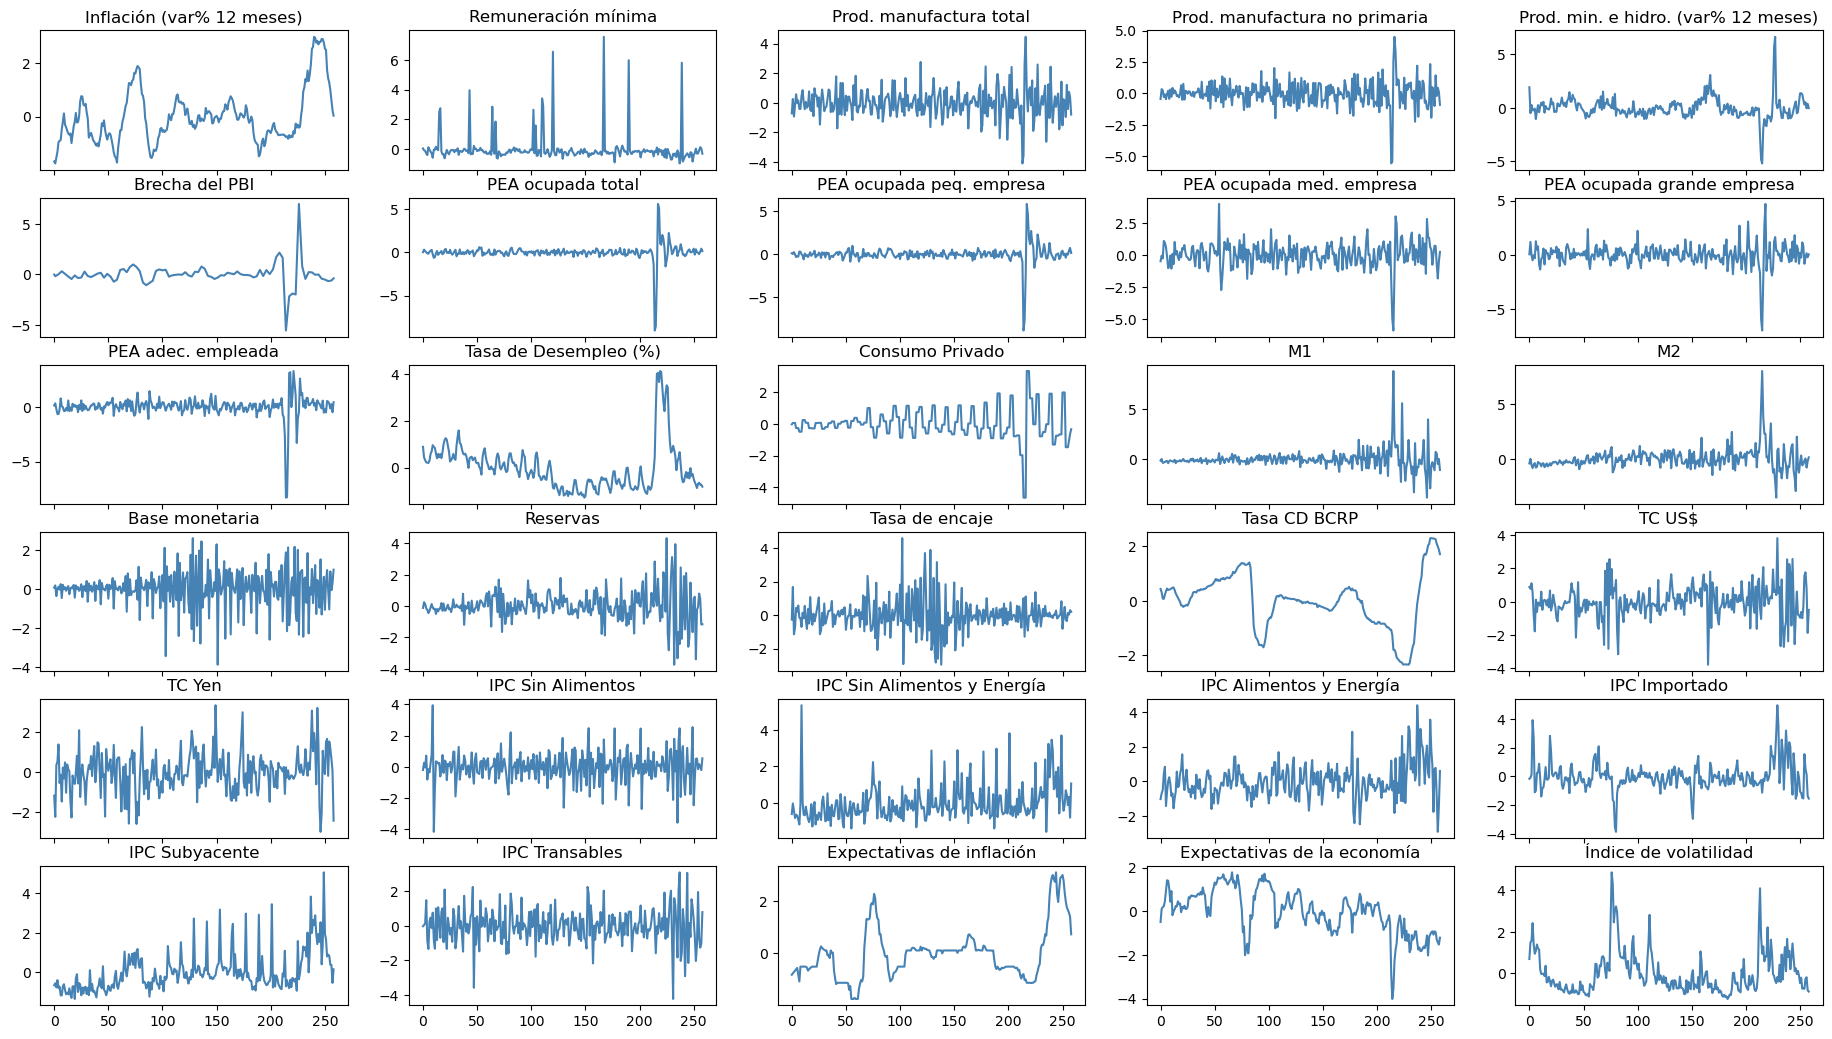

In [224]:
df_scaled = pd.DataFrame(scale.fit_transform(df))

# Graph of parameters
df_scaled.iloc[:, 1:].plot(kind ='line',
            subplots = True,
            figsize = (23,17),
            title = ['Inflación (var% 12 meses)', 'Remuneración mínima', 'Prod. manufactura total', 'Prod. manufactura no primaria', 'Prod. min. e hidro. (var% 12 meses)',
                     'Brecha del PBI', 'PEA ocupada total', 'PEA ocupada peq. empresa', 'PEA ocupada med. empresa', 'PEA ocupada grande empresa', 
                     'PEA adec. empleada', 'Tasa de Desempleo (%)', 'Consumo Privado', 'M1', 'M2', 
                     'Base monetaria', 'Reservas', 'Tasa de encaje', 'Tasa CD BCRP', 'TC US$', 
                     'TC Yen', 'IPC Sin Alimentos', 'IPC Sin Alimentos y Energía', 'IPC Alimentos y Energía', 'IPC Importado', 
                     'IPC Subyacente', 'IPC Transables', 'Expectativas de inflación', 'Expectativas de la economía', 'Índice de volatilidad'],
            legend = False,
            layout = (8,5),
            sharex = True,
            color = 'steelblue')
plt.show()

In [ ]:
# Correlation matrix
corrmat = round(df_scaled.corr(),2)
mask = np.triu(np.ones_like(corrmat,dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corrmat,vmax=1,square=True,annot=True,mask=mask)